# Homework 2: More Exploratory Data Analysis
## Gene Expression Data and Election Polls 

Due: Thursday, October 2, 2014 11:59 PM

<a href=https://raw.githubusercontent.com/cs109/2014/master/homework/HW2.ipynb download=HW2.ipynb> Download this assignment</a>

#### Submission Instructions
To submit your homework, create a folder named lastname_firstinitial_hw# and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code. Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. If we cannot access your work because these directions are not followed correctly, we will not grade your work.


---

## Introduction

John Tukey wrote in [Exploratory Data Analysis, 1977](http://www.amazon.com/Exploratory-Data-Analysis-Wilder-Tukey/dp/0201076160/ref=pd_bbs_sr_2/103-4466654-5303007?ie=UTF8&s=books&qid=1189739816&sr=8-2): "The greatest value of a picture is when it forces us to notice what we never expected to see." In this assignment we will continue using our exploratory data analysis tools, but apply it to new sets of data: [gene expression](http://en.wikipedia.org/wiki/Gene_expression) and polls from the [2012 Presidental Election](http://en.wikipedia.org/wiki/United_States_presidential_election,_2012) and from the [2014 Senate Midterm Elections](http://en.wikipedia.org/wiki/United_States_Senate_elections,_2014).   

**First**: You will use exploratory data analysis and apply the [singular value decomposition](http://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) to a gene expression data matrix to determine if the the date that the gene expression samples are processed has large effect on the variability seen in the data.  

**Second**: You will use the polls from the 2012 Presidential Elections to determine (1) Is there a pollster bias in presidential election polls? and (2) Is the average of polls better than just one poll?

**Finally**: You will use the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to extract the polls for the current 2014 Senate Midterm Elections and provide a preliminary prediction of the result of each state.

#### Data

We will use the following data sets: 

1. A gene expression data set called `exprs_GSE5859.csv` and sample annotation table called `sampleinfo_GSE5859.csv` which are both available on Github in the 2014_data repository: [expression data set](https://github.com/cs109/2014_data/blob/master/exprs_GSE5859.csv) and [sample annotation table](https://github.com/cs109/2014_data/blob/master/sampleinfo_GSE5859.csv).  

2. Polls from the [2012 Presidential Election: Barack Obama vs Mitt Romney](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama). The polls we will use are from the [Huffington Post Pollster](http://elections.huffingtonpost.com/pollster).  

3. Polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api). 

---

## Load Python modules

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import requests 
from StringIO import StringIO
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations

## Problem 1

In this problem we will be using a [gene expression](http://en.wikipedia.org/wiki/Gene_expression) data set obtained from a [microarray](http://en.wikipedia.org/wiki/DNA_microarray) experiement [Read more about the specific experiment here](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE5859).  There are two data sets we will use:  

1. The gene expression intensities where the rows represent the features on the microarray (e.g. genes) and the columsns represent the different microarray samples.  

2. A table that contains the information about each of the samples (columns in the gene expression data set) such as the sex, the age, the treatment status, the date the samples were processed.  Each row represents one sample. 

#### Problem 1(a) 
Read in the two files from Github: [exprs_GSE5859.csv](https://github.com/cs109/2014_data/blob/master/exprs_GSE5859.csv) and [sampleinfo_GSE5859.csv](https://github.com/cs109/2014_data/blob/master/sampleinfo_GSE5859.csv) as pandas DataFrames called `exprs` and `sampleinfo`. Use the gene names as the index of the `exprs` DataFrame.

In [2]:
# https://github.com/cs109/2014_data/blob/master/exprs_GSE5859.csv
# https://github.com/dennisi/2014_data/blob/master/exprs_GSE5859.csv
# https://github.com/cs109/2014_data/blob/master/sampleinfo_GSE5859.csv
# https://github.com/dennisi/2014_data/blob/master/sampleinfo_GSE5859.csv
url_sample = "https://raw.githubusercontent.com/dennisi/2014_data/master/sampleinfo_GSE5859.csv"
sampleinfo = pd.read_csv(url_sample)
print(sampleinfo.shape)
print(sampleinfo.head())

(208, 4)
  ethnicity        date         filename sex
0       CEU  2003-02-04  GSM25349.CEL.gz   M
1       CEU  2003-02-04  GSM25350.CEL.gz   M
2       CEU  2002-12-17  GSM25356.CEL.gz   M
3       CEU  2003-01-30  GSM25357.CEL.gz   M
4       CEU  2003-01-03  GSM25358.CEL.gz   M


In [3]:
url_exprs = "https://raw.githubusercontent.com/dennisi/2014_data/master/exprs_GSE5859.csv"
# Use the gene names as the index of the exprs DataFrame
exprs = pd.read_csv(url_exprs, index_col=0)
#                   index_col=0
print(exprs.shape)
exprs.head()

(8793, 208)


,GSM25581.CEL.gz,GSM25681.CEL.gz,GSM136524.CEL.gz,GSM136707.CEL.gz,GSM25553.CEL.gz,GSM136676.CEL.gz,GSM136711.CEL.gz,GSM136542.CEL.gz,GSM136535.CEL.gz,GSM25399.CEL.gz,...,GSM48650.CEL.gz,GSM25687.CEL.gz,GSM25685.CEL.gz,GSM136549.CEL.gz,GSM25427.CEL.gz,GSM25525.CEL.gz,GSM25349.CEL.gz,GSM136727.CEL.gz,GSM25626.CEL.gz,GSM136725.CEL.gz
1007_s_at,6.333951,5.736190,6.156754,6.513010,6.061013,6.506493,6.863426,6.369645,6.646321,5.810930,...,7.082636,6.315866,7.010165,6.460107,6.122355,6.330314,6.627014,6.133068,6.419444,6.488579
1053_at,7.255622,7.399993,7.491967,7.006123,7.250995,7.082581,6.842236,7.048487,7.042361,6.666625,...,6.599718,7.412731,7.274429,6.928642,7.168782,7.235648,6.939184,7.280781,6.351776,7.517410
117_at,5.760106,4.825169,5.039387,5.414160,5.205697,5.300078,5.099337,5.156459,5.736109,5.807496,...,6.231457,5.240717,5.275062,5.759827,5.409720,5.491938,5.113570,5.401876,5.537605,5.247190
121_at,6.935451,7.025210,7.543667,7.959781,7.223323,8.006816,8.102504,7.434617,7.532321,7.711461,...,8.215096,7.677593,7.923624,7.219401,7.432338,6.785174,7.833862,7.607461,7.302935,7.331864
1255_g_at,3.597872,3.108801,3.128269,3.364947,3.125909,3.186834,3.311022,3.092042,3.167737,2.969579,...,3.331424,3.043856,3.151900,3.132253,3.250600,2.984125,3.152269,3.225123,3.222731,3.175846


In [ ]:
# Use the gene names as the index of the exprs DataFrame
#exprs.index = exprs[exprs.columns[0]]
#exprs = exprs.drop(exprs.columns[0], axis = 1)
#exprs.index.name = 'gene_name'
#exprs.head()

Make sure the order of the columns in the gene expression DataFrame match the order of file names in the sample annotation DataFrame. If the order of the columns the `exprs` DataFrame do not match the order of the file names in the `sampleinfo` DataFrame, reorder the columns in the `exprs` DataFrame. 

**Note**: The column names of the gene expression DataFrame are the filenames of the orignal files from which these data were obtained.  

**Hint**: The method `list.index(x)` [[read here](https://docs.python.org/2/tutorial/datastructures.html)] can be used to return the index in the list of the first item whose value is x. It is an error if there is no such item. To check if the order of the columns in `exprs` matches the order of the rows in `sampleinfo`, you can check using the method `.all()` on a Boolean or list of Booleans: 

Example code: `(exprs.columns == sampleinfo.filename).all()`

In [4]:
sampleinfo.sort(['filename'], inplace=True)
#sampleinfo.head() #GSM136441

In [5]:
lst = exprs.columns.tolist()
lst.sort() # inplace sort

exprs = exprs[lst]
(exprs.columns == sampleinfo.filename).all()

True

Show the head of the two tables: `exprs` and `sampleinfo`. 

In [6]:
sampleinfo.head()

,ethnicity,date,filename,sex
99,ASN,2005-05-13,GSM136441.CEL.gz,F
100,ASN,2005-06-10,GSM136442.CEL.gz,F
101,ASN,2005-06-10,GSM136443.CEL.gz,M
102,ASN,2005-06-10,GSM136444.CEL.gz,M
103,ASN,2005-06-10,GSM136445.CEL.gz,F


In [7]:
exprs.head()

,GSM136441.CEL.gz,GSM136442.CEL.gz,GSM136443.CEL.gz,GSM136444.CEL.gz,GSM136445.CEL.gz,GSM136506.CEL.gz,GSM136507.CEL.gz,GSM136508.CEL.gz,GSM136509.CEL.gz,GSM136510.CEL.gz,...,GSM48655.CEL.gz,GSM48656.CEL.gz,GSM48657.CEL.gz,GSM48658.CEL.gz,GSM48660.CEL.gz,GSM48661.CEL.gz,GSM48662.CEL.gz,GSM48663.CEL.gz,GSM48664.CEL.gz,GSM48665.CEL.gz
1007_s_at,6.302996,6.444051,6.238090,6.499574,6.454842,6.171587,6.517539,6.543954,6.379983,6.502051,...,6.237984,6.704893,6.720599,6.501510,6.558100,6.618286,6.869995,5.981000,6.403285,6.248702
1053_at,7.097359,7.099125,7.308965,6.889842,6.880901,7.123658,7.689282,7.546708,7.702533,7.302209,...,7.169030,6.658916,7.280992,7.066686,7.386702,6.407958,7.089180,7.120923,7.018998,7.155419
117_at,5.204992,5.448902,5.440455,5.386826,5.147856,5.298285,5.562001,5.402622,5.398616,5.395087,...,5.095864,5.308445,5.347524,5.600514,5.232676,5.630720,4.944748,5.275577,5.770358,5.616842
121_at,7.380881,7.638094,7.720119,7.822919,7.914191,7.636683,7.612557,7.892544,7.511478,7.993732,...,7.220390,7.712825,7.671745,7.437535,7.714650,7.416252,7.746448,8.001434,7.626723,7.452299
1255_g_at,3.200968,3.327960,3.192055,3.538002,3.352793,3.207580,3.107306,3.242779,3.212051,3.440186,...,2.926689,3.103790,3.016090,3.009983,3.151203,3.199709,3.159496,3.149710,3.242780,3.433125


#### Problem 1(b)

Extract the year and month as integers from the `sampleinfo` table. 

**Hint**: To convert a Series or a column of a pandas DataFrame that contains a date-like object, you can use the `to_datetime` function [[read here](http://pandas.pydata.org/pandas-docs/stable/timeseries.html)].  This will create a `DatetimeIndex` which can be used to extract the month and year for each row in the DataFrame. 

In [8]:
sampleinfo["date"] = pd.to_datetime(sampleinfo.date)
sampleinfo["month"] = map(lambda x: x.month, sampleinfo.date)
sampleinfo["year"] = map(lambda x: x.year, sampleinfo.date)
#pd.to_datetime(sampleinfo.date).dt.year
#pd.to_datetime(sampleinfo.date).dt.month

#### Problem 1(c)

Convert the dates in the `date` column from the `sampleinfo` table into days since October 31, 2002. Add a column to the `sampleinfo` DataFrame titled `elapsedInDays` containing the days since October 31, 2002.  Show the head of the `sampleinfo` DataFrame which includes the new column.  

**Hint**: Use the `datetime` module to create a new `datetime` object for the specific date October 31, 2002. Then, subtract the October 31, 2002 date from each date from the `date` column in the `sampleinfo` DataFrame. 

In [9]:
#from datetime import datetime
#from datetime import date

oct31 = pd.to_datetime('2002-10-31') #t = pd.Timestamp('2002-10-31')
sampleinfo['elapsedInDays'] = map(lambda x: (x - oct31).days, sampleinfo.date)
sampleinfo.head()

,ethnicity,date,filename,sex,month,year,elapsedInDays
99,ASN,2005-05-13,GSM136441.CEL.gz,F,5,2005,925
100,ASN,2005-06-10,GSM136442.CEL.gz,F,6,2005,953
101,ASN,2005-06-10,GSM136443.CEL.gz,M,6,2005,953
102,ASN,2005-06-10,GSM136444.CEL.gz,M,6,2005,953
103,ASN,2005-06-10,GSM136445.CEL.gz,F,6,2005,953


#### Problem 1(d)

Use exploratory analysis and the singular value decomposition (SVD) of the gene expression data matrix to determine if the date the samples were processed has large effect on the variability seen in the data or if it is just ethnicity (which is confounded with date). 

**Hint**: See the end of the [lecture from 9/23/2014 for help with SVD](http://nbviewer.ipython.org/github/cs109/2014/blob/master/lectures/lecture07/data_scraping_transcript.ipynb). 

First subset the the `sampleinfo` DataFrame to include only the CEU ethnicity.  Call this new subsetted DataFrame `sampleinfoCEU`.  Show the head of `sampleinfoCEU` DataFrame. 

In [10]:
sampleinfoCEU = sampleinfo[sampleinfo.ethnicity == 'CEU']
print(sampleinfoCEU.shape)
sampleinfoCEU.head()

(102, 7)


,ethnicity,date,filename,sex,month,year,elapsedInDays
204,CEU,2005-02-16,GSM136725.CEL.gz,F,2,2005,839
205,CEU,2005-02-16,GSM136726.CEL.gz,M,2,2005,839
206,CEU,2005-06-10,GSM136727.CEL.gz,M,6,2005,953
0,CEU,2003-02-04,GSM25349.CEL.gz,M,2,2003,96
1,CEU,2003-02-04,GSM25350.CEL.gz,M,2,2003,96


Next, subset the `exprs` DataFrame to only include the samples with the CEU ethnicity. Name this new subsetted DataFrame `exprsCEU`. Show the head of the `exprsCEU` DataFrame. 

In [11]:
exprsCEU = exprs[sampleinfoCEU.filename]
#exprsCEU = exprs.loc[:, sampleinfoCEU.filename.tolist()]
exprsCEU.head()

,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,...,GSM48655.CEL.gz,GSM48656.CEL.gz,GSM48657.CEL.gz,GSM48658.CEL.gz,GSM48660.CEL.gz,GSM48661.CEL.gz,GSM48662.CEL.gz,GSM48663.CEL.gz,GSM48664.CEL.gz,GSM48665.CEL.gz
1007_s_at,6.488579,6.809481,6.133068,6.627014,6.249807,5.934128,6.145268,6.091270,6.041186,6.050375,...,6.237984,6.704893,6.720599,6.501510,6.558100,6.618286,6.869995,5.981000,6.403285,6.248702
1053_at,7.517410,7.200596,7.280781,6.939184,6.818038,7.047962,7.422477,7.272361,7.128216,6.750719,...,7.169030,6.658916,7.280992,7.066686,7.386702,6.407958,7.089180,7.120923,7.018998,7.155419
117_at,5.247190,5.237239,5.401876,5.113570,5.074096,5.371201,5.266550,5.342047,5.063876,5.315898,...,5.095864,5.308445,5.347524,5.600514,5.232676,5.630720,4.944748,5.275577,5.770358,5.616842
121_at,7.331864,7.357102,7.607461,7.833862,7.780682,7.458197,7.655948,7.546555,7.072670,7.092984,...,7.220390,7.712825,7.671745,7.437535,7.714650,7.416252,7.746448,8.001434,7.626723,7.452299
1255_g_at,3.175846,3.105092,3.225123,3.152269,3.111747,3.018932,3.154545,3.107954,3.224284,3.114241,...,2.926689,3.103790,3.016090,3.009983,3.151203,3.199709,3.159496,3.149710,3.242780,3.433125


Check to make sure the order of the columns in the `exprsCEU` DataFrame matches the rows in the `sampleinfoCEU` DataFrame.  

In [12]:
(exprsCEU.columns == sampleinfoCEU.filename).all()

True

Compute the average gene expression intensity in the `exprsCEU` DataFrame across all the samples. For each sample in the `exprsCEU` DataFrame, subtract the average gene expression intensity from each of the samples. Show the head of the mean normalized gene expression data.  

In [13]:
# BOMBED! #exprsCEU.subtract( exprsCEU.mean(axis='columns'), axis='columns' ) 
# BOMBED! #exprsCEU - exprsCEU.mean(axis='columns') 
exprsCEU0 = exprsCEU.subtract( exprsCEU.mean(axis='columns'), axis='index' )#.mean(axis='columns')
exprsCEU0.head()
# quick check of normalization
#exprsCEU0.mean(axis='columns').round(2).head()

,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,...,GSM48655.CEL.gz,GSM48656.CEL.gz,GSM48657.CEL.gz,GSM48658.CEL.gz,GSM48660.CEL.gz,GSM48661.CEL.gz,GSM48662.CEL.gz,GSM48663.CEL.gz,GSM48664.CEL.gz,GSM48665.CEL.gz
1007_s_at,0.226624,0.547526,-0.128887,0.365059,-0.012149,-0.327827,-0.116687,-0.170685,-0.220769,-0.211580,...,-0.023971,0.442938,0.458643,0.239554,0.296144,0.356331,0.608040,-0.280956,0.141330,-0.013254
1053_at,0.442193,0.125379,0.205564,-0.136032,-0.257178,-0.027254,0.347260,0.197144,0.053000,-0.324497,...,0.093813,-0.416301,0.205776,-0.008531,0.311485,-0.667259,0.013964,0.045706,-0.056219,0.080203
117_at,-0.356936,-0.366887,-0.202251,-0.490556,-0.530031,-0.232926,-0.337577,-0.262080,-0.540250,-0.288228,...,-0.508262,-0.295682,-0.256603,-0.003613,-0.371451,0.026594,-0.659379,-0.328549,0.166231,0.012716
121_at,-0.083972,-0.058733,0.191626,0.418026,0.364847,0.042362,0.240113,0.130720,-0.343165,-0.322852,...,-0.195446,0.296990,0.255909,0.021700,0.298814,0.000417,0.330612,0.585598,0.210887,0.036463
1255_g_at,0.041912,-0.028842,0.091189,0.018335,-0.022187,-0.115002,0.020611,-0.025980,0.090351,-0.019693,...,-0.207245,-0.030144,-0.117844,-0.123951,0.017269,0.065775,0.025562,0.015776,0.108846,0.299192


Using this mean normalized gene expression data, compute the projection to the first Principal Component (PC1).  

**Hint**: Use the `numpy.linalg.svd()` function in the `numpy.linalg` module (or the `scipy.linalg.svd()` function in the `scipy.linalg` module) to apply an [singular value decomposition](http://en.wikipedia.org/wiki/Singular_value_decomposition) to a matrix.  

In [14]:
#import numpy.linalg
import scipy.linalg
#matrix = np.column_stack()
U,s,Vh = scipy.linalg.svd(exprsCEU0.values)

In [15]:
import scipy.linalg
#S = scipy.linalg.diagsvd(s, s.size, s.size)
V = Vh.T


In [ ]:
#plt.plot([0, V[0,0]], [0, V[1,0]], c='r', linewidth=3.0)
#plt.plot([0, V[0,1]], [0, V[1,1]], c='b', linewidth=3.0)
#plt.axis([-.3,.3,-.3,.3])
#plt.show()

Create a histogram using the values from PC1.  Use a bin size of 25.  

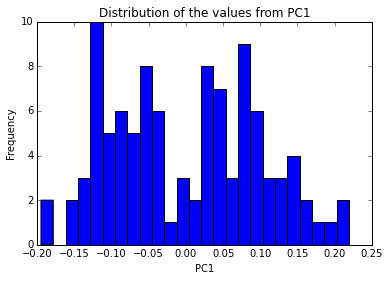

In [16]:
plt.hist(V[:,0], bins = 25)
plt.xlabel('PC1')
plt.ylabel('Frequency')
plt.title('Distribution of the values from PC1')

In [ ]:
#projection = np.dot(U, S[:,:1])
#projection2 = np.dot(exprsCEU0, V[:,:1])
#np.allclose(projection, projection2)

Create a scatter plot with the days since October 31, 2002 on the x-axis and PC1 on the y-axis.

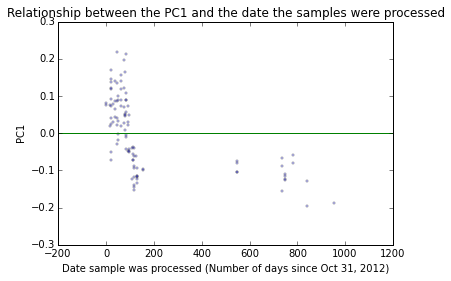

In [34]:
plt.scatter(sampleinfoCEU.elapsedInDays, V[:,0], s=5, alpha=0.25)
plt.xlabel('Date sample was processed (Number of days since Oct 31, 2012)')
plt.ylabel('PC1')
plt.title('Relationship between the PC1 and the date the samples were processed')

plt.axhline(y=0, color='g')

Around what day do you notice a difference in the way the samples were processed?

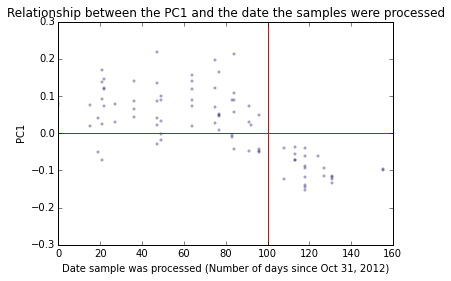

In [33]:
plt.scatter(sampleinfoCEU.elapsedInDays, V[:,0], s=5, alpha=0.25)
plt.xlim(0,160)
plt.xlabel('Date sample was processed (Number of days since Oct 31, 2012)')
plt.ylabel('PC1')
plt.title('Relationship between the PC1 and the date the samples were processed')
plt.axvline(x=100, color='r')
plt.axhline(y=0, color='g')

Answer:

## Discussion for Problem 1

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---


## Problem 2: Is there a pollster bias in presidential election polls?

#### Problem 2(a)

The [HuffPost Pollster](http://elections.huffingtonpost.com/pollster) contains many political polls. You can access these polls from individual races as a CSV but you can also access polls through the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to access the data.  

Read in the polls from the [2012 Presidential Election: Barack Obama vs Mitt Romney](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama) into a pandas DataFrame called `election`. For this problem, you may read in the polls for this race directly using [the CSV file](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv) available from the HuffPost Pollster page.

In [4]:
url_election = "http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv"
election = pd.read_csv(url_election).convert_objects(convert_dates="coerce", convert_numeric=True)

Show the head of the `election` DataFrame. 

In [5]:
print(election.shape)
election.head()

(589, 14)


,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Pollster URL,Source URL,Partisan,Affiliation
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06 2000-01-01 08:40:26 UTC,1000,Likely Voters,Live Phone,47,47,6,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None
1,UPI/CVOTER,2012-11-03,2012-11-05,2012-11-05 2000-01-01 18:30:15 UTC,3000,Likely Voters,Live Phone,49,48,NaN,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06 2000-01-01 09:22:02 UTC,872,Likely Voters,Automated Phone,48,48,4,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None
3,JZ Analytics/Newsmax,2012-11-03,2012-11-05,2012-11-06 2000-01-01 07:38:41 UTC,1041,Likely Voters,Internet,47,47,6,http://elections.huffingtonpost.com/pollster/p...,NaN,Sponsor,Rep
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06 2000-01-01 08:47:50 UTC,1500,Likely Voters,Automated Phone,48,49,NaN,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None


How many polls were conducted in November? Define this number as M.  

**Hint**: Subset the `election` DataFrame for only dates in the `Start Date` column that are in November 2012.  

In [9]:
election.dtypes
election['Start Date'].unique()
election['start_date'] = pd.to_datetime(election['Start Date'])
Nov2012polls = election[(election.start_date.dt.year == 2012) & 
             (election.start_date.dt.month == 11)]
M = Nov2012polls.shape[0] #.start_date.unique()
# Todo: Remove duplicate Pollsters
print(M)

19


Answer: 19 polls in November (with 1 duplicate Pollster)

What was the median of the number of observations in the November polls? Define this quantity as N. 

In [10]:
N = Nov2012polls['Number of Observations'].median()
print(N)

1200.0


Answer: The median number of observations was 1200.

#### Problem 2(b)

Using the median sample size $N$ from Problem 1(a), simulate the results from a single poll:  simulate the number of votes for Obama out of a sample size $N$ where $p$ = 0.53 is the percent of voters who are voting for Obama.  

**Hint**: Use the binomial distribution with parameters $N$ and $p$ = 0.53. 

In [11]:
#your code here
np.random.binomial(N, 0.53)*1.0 / N

0.5308333333333334

Now, perform a Monte Carlo simulation to obtain the estimated percentage of Obama votes with a sample size $N$ where $N$ is the median sample size calculated in Problem 2(a). Let $p$=0.53 be the percent of voters are voting for Obama. 

**Hint**: You will repeat the simulation above 1,000 times and plot the distribution of the estimated *percent* of Obama votes from a single poll.  The results from the single poll you simulate is random variable and will be different every time you sample. 

In [26]:
obama_mc = np.random.binomial(N, 0.53, 1000)*1.0 / N

Plot the distribution of the estimated percentage of Obama votes from your single poll. What is the distribution of the estimated percentage of Obama votes? 

(array([   1.,    3.,   18.,   87.,  183.,  278.,  236.,  133.,   54.,    7.]),
 array([ 0.46916667,  0.47975   ,  0.49033333,  0.50091667,  0.5115    ,
         0.52208333,  0.53266667,  0.54325   ,  0.55383333,  0.56441667,
         0.575     ]),
 <a list of 10 Patch objects>)

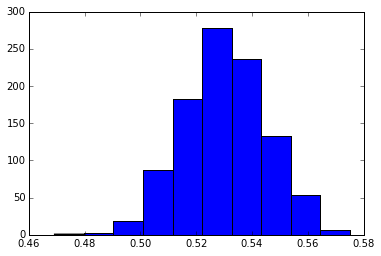

In [30]:
plt.hist(obama_mc)

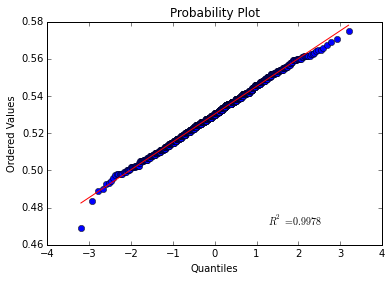

In [28]:
# ToDo: make Q-Q plot
import scipy.stats as stats
stats.probplot(obama_mc, plot=plt)
plt.show()

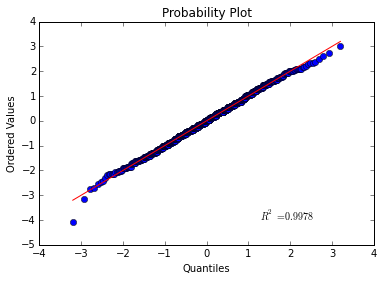

In [29]:
stats.probplot((obama_mc - np.mean(obama_mc)) / np.std(obama_mc, ddof=1), dist='norm', plot=plt)
plt.show()

Answer: From the histogram and qqplot(s) we can see the distribution is normal

What is the standard error (SE) of the estimated percentage from the poll. 

**Hint**: Remember the SE is the standard deviation (SD) of the distribution of a random variable. 

In [33]:
print(np.std(obama_mc, ddof=1))
obama_mc.std()

0.0149289813054


0.014921514947663101

#### Problem 2(c)

Now suppose we run M polls where M is the number of polls that happened in November (calculated in Problem 2(a)). Run 1,000 simulations and compute the mean of the M polls for each simulation. 

In [34]:
pollN = range(1000)
polls_mc = []
for poll in pollN:
    mc = np.random.binomial(N, 0.53, M)*1.0 / N
    polls_mc.append(mc.mean())

What is the distribution of the average of polls?

**Hint**: Show a plot. 

(array([  13.,   35.,   89.,  165.,  256.,  229.,  131.,   62.,   17.,    3.]),
 array([ 0.52030702,  0.52236404,  0.52442105,  0.52647807,  0.52853509,
         0.53059211,  0.53264912,  0.53470614,  0.53676316,  0.53882018,
         0.54087719]),
 <a list of 10 Patch objects>)

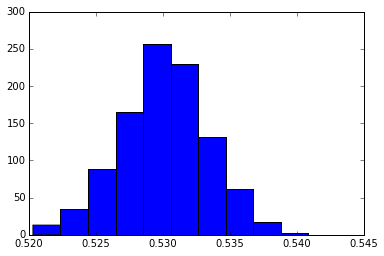

In [39]:
plt.hist(polls_mc)

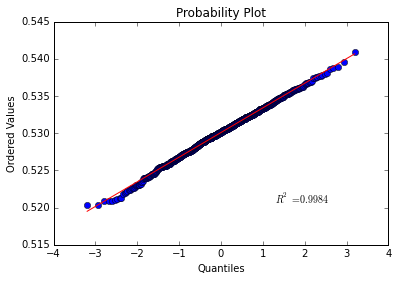

In [37]:
# show probability plot
stats.probplot(polls_mc, plot=plt)
plt.show()

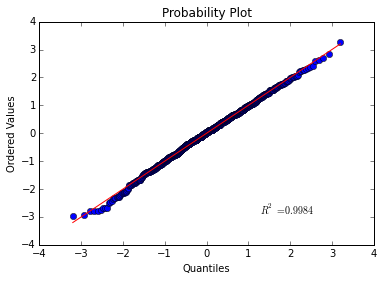

In [38]:
stats.probplot((polls_mc - np.mean(polls_mc)) / np.std(polls_mc, ddof=1), plot=plt)
plt.show()

Answer: using histogram and qqplot we can see that this distributioin is very similar to normal

What is the standard error (SE) of the average of polls? 

In [40]:
np.std(polls_mc, ddof=1)

0.0033057095646014871

Answer: 

Is the SE of the average of polls larger, the same, or smaller than that the SD of a single poll (calculated in Problem 2(b))? By how much?

**Hint**: Compute a ratio of the two quantities.  

In [41]:
print(np.std(polls_mc, ddof = 1)/np.std(obama_mc, ddof = 1))

0.221429010927


Answer: 

#### Problem 2(d) 

Repeat Problem 2(c) but now record the *across poll* standard deviation in each simulation. 

In [42]:
pollN = range(1000)
polls_mc_std = []
for poll in pollN:
    mc = np.random.binomial(N, 0.53, M)*1.0 / N
    polls_mc_std.append(mc.std())

What is the distribution of the *across M polls* standard deviation?

**Hint**: Show a plot. 

(array([   7.,   56.,  127.,  221.,  238.,  192.,  105.,   36.,   12.,    6.]),
 array([ 0.00731681,  0.00878927,  0.01026172,  0.01173418,  0.01320664,
         0.0146791 ,  0.01615155,  0.01762401,  0.01909647,  0.02056893,
         0.02204138]),
 <a list of 10 Patch objects>)

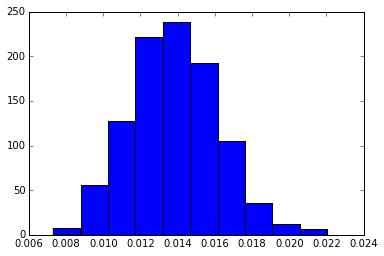

In [43]:
plt.hist(polls_mc_std)

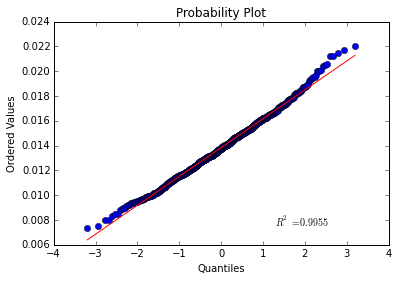

In [44]:
stats.probplot(polls_mc_std, plot=plt)
plt.show()

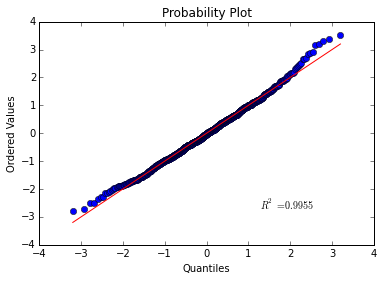

In [45]:
stats.probplot((polls_mc_std - np.mean(polls_mc_std)) / np.std(polls_mc_std, ddof=1), plot=plt)
plt.show()

Answer: 

#### Problem 2(e) 

What is the standard deviation of M polls in our real (not simulated) 2012 presidential election data ? 

In [50]:
Nov2012polls.Obama.std(ddof=1) / 100

0.010841764600337107

Is this larger, the same, or smaller than what we expeced if polls were not biased.

In [53]:
Nov2012polls.Obama.std(ddof=1) / (100 * np.mean(polls_mc_std))

0.78344952765126108

Answer: 

#### Problem 2(f)

**For AC209 Students**: Learn about the normal approximation for the binomial distribution and derive the results of Problem 2(b) and 2(c) analytically (using this approximation). Compare the results obtained analytically to those obtained from simulations.

In [ ]:
#your code here

Answer: 

## Discussion for Problem 2

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---


## Problem 3: Is the average of polls better than just one poll?

#### Problem 3(a)

Most undecided voters vote for one of the two candidates at the election. Therefore, the reported percentages underestimate the final value of both candidates. However, if we assume the undecided will split evenly, then the observed difference should be an unbiased estimate of the final difference. 

Add a new column to the `election` DataFrame containg the difference between Obama and Romeny called `Diff`. 

In [46]:
election['diff'] = (election.Obama / 100.0) - (election.Romney / 100.0)

In [47]:
election.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Pollster URL,Source URL,Partisan,Affiliation,start_date,diff
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06 2000-01-01 08:40:26 UTC,1000,Likely Voters,Live Phone,47,47,6,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None,2012-11-04,0.00
1,UPI/CVOTER,2012-11-03,2012-11-05,2012-11-05 2000-01-01 18:30:15 UTC,3000,Likely Voters,Live Phone,49,48,NaN,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None,2012-11-03,0.01
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06 2000-01-01 09:22:02 UTC,872,Likely Voters,Automated Phone,48,48,4,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None,2012-11-03,0.00
3,JZ Analytics/Newsmax,2012-11-03,2012-11-05,2012-11-06 2000-01-01 07:38:41 UTC,1041,Likely Voters,Internet,47,47,6,http://elections.huffingtonpost.com/pollster/p...,NaN,Sponsor,Rep,2012-11-03,0.00
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06 2000-01-01 08:47:50 UTC,1500,Likely Voters,Automated Phone,48,49,NaN,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None,2012-11-03,-0.01


#### Problem 3(b)

Make a plot of the differences for the week before the election (e.g. 5 days) where the days are on the x-axis and the differences are on the y-axis.  Add a horizontal line showing 3.9%: the difference between Obama and Romney on election day.

In [92]:
#election[election.start_date >= (election_day - 7)].shape

ValueError: Cannot add integral value to Timestamp without offset.

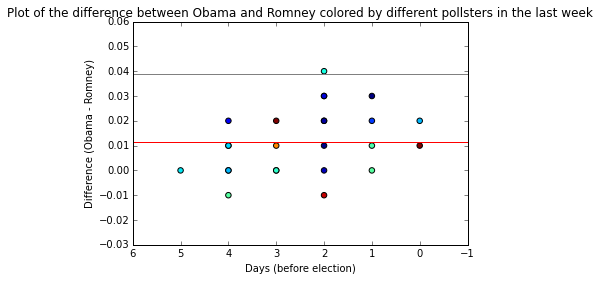

In [68]:
election_day = pd.to_datetime('2012-11-06')
week_before_election_day = pd.to_datetime('2012-10-30')
data = election[election.start_date >= week_before_election_day] # .shape # (25, 16)
#print(np.size(map(lambda x: (x - week_before_election_day).days , data.start_date)))
#print(np.size(data['diff']))
#data['diff']
#election[election.start_date >= week_before_election_day]["diff"].hist()

color_map = {}
for i, p in enumerate(set(data.Pollster)):
    color_map[p] = np.random.rand();
    
plt.scatter(map(lambda x: (x - week_before_election_day).days , data.start_date), 
            data['diff'], 
            c = map(lambda x: color_map[x], data.Pollster),  
            s=30)
plt.axhline(y=0.039, c="gray")
plt.axhline(y=np.mean(data['diff']), c="r")
plt.xlabel("Days (before election)")
plt.gca().invert_xaxis()
plt.ylabel("Difference (Obama - Romney)")
plt.title("Plot of the difference between Obama and Romney colored by different pollsters in the last week")


#### Problem 3(c) 

Make a plot showing the differences by pollster where the pollsters are on the x-axis and the differences on the y-axis. 

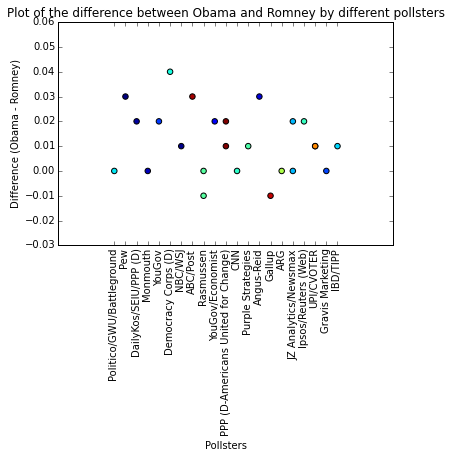

In [69]:
pollster_map = {}

polls = list(set(data.Pollster))

for i, p in enumerate(polls):
    pollster_map[p] = i
    
#election[election.start_date >= week_before_election_day]["diff"].plot(kind='barh', xlabel = election.Pollster)
plt.scatter(map(lambda x: pollster_map[x],data.Pollster), 
            data['diff'], 
            c = map(lambda x: color_map[x], data.Pollster), 
            s=30)
plt.xticks(range(len(polls)), polls, rotation = 90)
plt.xlabel("Pollsters")
plt.ylabel("Difference (Obama - Romney)")
plt.title("Plot of the difference between Obama and Romney by different pollsters")
plt.show()

Is the *across poll* difference larger than the *between pollster* difference? 

Answer: 

#### Problem 3(d)

Take the average for each pollster and then compute the average of that. Given this difference how confident would you have been of an Obama victory?

**Hint**: Compute an estimate of the SE of this average based exclusively on the observed data. 

In [ ]:
#your code here

Answer: 

#### Problem 3(e)

**For AC209 Students**: Show the difference against time and see if you can detect a trend towards the end. Use this trend to see if it improves the final estimate.

In [ ]:
#your code here

Answer: 

## Discussion for Problem 3

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---


## Problem 4

In this last problem, we will use the polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to create a preliminary prediction of the result of each state. 

The HuffPost Pollster API allows you to access the data as a CSV or a JSON response by tacking ".csv" or ".json" at the end of the URLs. For example the 2012 Presidential Election could be accessed as a [.json](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.json) instead of a [.csv](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv)

#### Problem 4(a)

Read in the polls for **all** of the 2014 Senate Elections using the HuffPost API. For example, we can consider the [2014 Senate race in Kentucky between Mitch McConnell and Alison Grimes](http://elections.huffingtonpost.com/pollster/2014-kentucky-senate-mcconnell-vs-grimes). 

To search for the 2014 Senate races, use the `topics` parameter in the API [[read more about topics here](http://elections.huffingtonpost.com/pollster/api)].  

In [2]:
url_str = "http://elections.huffingtonpost.com/pollster/api/charts/?topic=2014-senate"

To list all the URLs related to the 2014 Senate races using the pollster API, we can use a list comprehension:

In [3]:
election_urls = [election['url'] + '.csv' for election in requests.get(url_str).json()]
election_urls

[u'http://elections.huffingtonpost.com/pollster/2014-kentucky-senate-mcconnell-vs-grimes.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-arkansas-senate-cotton-vs-pryor.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-michigan-senate-land-vs-peters.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-louisiana-senate-cassidy-vs-landrieu.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-new-hampshire-senate-brown-vs-shaheen.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-west-virginia-senate-capito-vs-tennant.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-new-hampshire-senate-bass-vs-shaheen.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-north-carolina-senate-tillis-vs-hagan.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-virginia-senate-gillespie-vs-warner.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-colorado-senate-gardner-vs-udall.csv',
 u'http://elections.huffingtonpost.com/pollster/2014-

Because there so many Senate races, we can create a dictionary of pandas DataFrames that will be keyed by the name of the election (a string). 

In [4]:
def build_frame(url):
    """
    Returns a pandas DataFrame object containing
    the data returned from the given url
    """
    source = requests.get(url).text
    
    # Use StringIO because pd.DataFrame.from_csv requires .read() method
    s = StringIO(source)
    
    return pd.DataFrame.from_csv(s, index_col=None).convert_objects(
            convert_dates="coerce", convert_numeric=True)

In [5]:
# Makes a dictionary of pandas DataFrames keyed on election string.
dfs = dict((election.split("/")[-1][:-4], build_frame(election)) for election in election_urls)

Show the head of the DataFrame containing the polls for the 2014 Senate race in Kentucky between McConnell and Grimes.

In [82]:
df = dfs['2014-kentucky-senate-mcconnell-vs-grimes']
df.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,McConnell,Grimes,Undecided,Pollster URL,Source URL,Partisan,Affiliation
0,PPP (D),2014-10-30,2014-11-01,2014-11-02 01:44:58,1503,Likely Voters,IVR/Online,50,42,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.publicpolicypolling.com/pdf/2014/PP...,Pollster,Dem
1,NBC/Marist,2014-10-27,2014-10-30,2014-11-02 14:37:22,556,Likely Voters,Live Phone,50,41,3,http://elections.huffingtonpost.com/pollster/p...,http://newscms.nbcnews.com/sites/newscms/files...,Nonpartisan,None
2,SurveyUSA/Courier-Journal/Herald-Leader/WHAS/WKYT,2014-10-25,2014-10-29,2014-10-30 23:33:59,597,Likely Voters,IVR/Online,48,43,6,http://elections.huffingtonpost.com/pollster/p...,http://www.surveyusa.com/client/PollReport.asp...,Nonpartisan,None
3,POS (R-Crossroads GPS),2014-10-25,2014-10-27,2014-10-30 20:56:18,600,Likely Voters,Live Phone,50,43,NaN,http://elections.huffingtonpost.com/pollster/p...,https://www.crossroadsgps.org/wp-content/uploa...,Sponsor,Rep
4,CBS/NYT/YouGov,2014-10-16,2014-10-23,2014-10-26 15:00:07,1502,Likely Voters,Internet,45,39,14,http://elections.huffingtonpost.com/pollster/p...,https://today.yougov.com/news/2014/09/07/battl...,Nonpartisan,None


#### Problem 4(b)

For each 2014 Senate race, create a preliminary prediction of the result for that state.

In [17]:
df.shape

(57, 14)

In [18]:
df.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,McConnell,Grimes,Undecided,Pollster URL,Source URL,Partisan,Affiliation
0,PPP (D),2014-10-30,2014-11-01,2014-11-02 01:44:58,1503,Likely Voters,IVR/Online,50,42,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.publicpolicypolling.com/pdf/2014/PP...,Pollster,Dem
1,NBC/Marist,2014-10-27,2014-10-30,2014-11-02 14:37:22,556,Likely Voters,Live Phone,50,41,3,http://elections.huffingtonpost.com/pollster/p...,http://newscms.nbcnews.com/sites/newscms/files...,Nonpartisan,None
2,SurveyUSA/Courier-Journal/Herald-Leader/WHAS/WKYT,2014-10-25,2014-10-29,2014-10-30 23:33:59,597,Likely Voters,IVR/Online,48,43,6,http://elections.huffingtonpost.com/pollster/p...,http://www.surveyusa.com/client/PollReport.asp...,Nonpartisan,None
3,POS (R-Crossroads GPS),2014-10-25,2014-10-27,2014-10-30 20:56:18,600,Likely Voters,Live Phone,50,43,NaN,http://elections.huffingtonpost.com/pollster/p...,https://www.crossroadsgps.org/wp-content/uploa...,Sponsor,Rep
4,CBS/NYT/YouGov,2014-10-16,2014-10-23,2014-10-26 15:00:07,1502,Likely Voters,Internet,45,39,14,http://elections.huffingtonpost.com/pollster/p...,https://today.yougov.com/news/2014/09/07/battl...,Nonpartisan,None


In [19]:
df.describe()

,Number of Observations,McConnell,Grimes,Undecided
count,57.000000,57.000000,57.000000,53.000000
mean,1016.070175,45.561404,42.561404,9.660377
std,676.743987,3.162377,2.751737,4.118175
min,500.000000,37.000000,36.000000,2.000000
25%,632.000000,43.000000,41.000000,7.000000
50%,807.000000,46.000000,42.000000,9.000000
75%,1153.000000,48.000000,45.000000,13.000000
max,5000.000000,52.000000,49.000000,19.000000


In [22]:
df['Pollster'].unique()
#df.Pollster.unique()

array(['PPP (D)', 'NBC/Marist',
       'SurveyUSA/Courier-Journal/Herald-Leader/WHAS/WKYT',
       'POS (R-Crossroads GPS)', 'CBS/NYT/YouGov', 'VCR (R-McConnell)',
       'Western Kentucky University', 'Rasmussen',
       'Gravis/Human Events (R)', 'FOX', 'Mellman (D-Grimes)',
       'Ipsos/Reuters', 'Magellan (R-National Mining Association)', 'CNN',
       'PPP (D-Americans for Tax Fairness Action Fund)',
       'POS (R-American Crossroads)', 'Wenzel Strategies (R)',
       'Hickman (D-Consumer Energy Alliance)', 'NYT/Kaiser',
       'PPP (D-MoveOn)', 'PPP (D-Americans United for Change)',
       'Gravis Marketing/Human Events (R)', 'Lake Research (D-MoveOn)',
       'DFM Research (D-SMART)',
       'Lake Research (D-Public Campaign Action Fund)',
       'PPP (D-Progressive Change Campaign Committee)',
       'PPP (D-Senate Majority PAC)'], dtype=object)

In [23]:
df['Start Date'].unique()

array(['2014-10-29T19:00:00.000000000-0500',
       '2014-10-26T19:00:00.000000000-0500',
       '2014-10-24T19:00:00.000000000-0500',
       '2014-10-15T19:00:00.000000000-0500',
       '2014-10-14T19:00:00.000000000-0500',
       '2014-10-10T19:00:00.000000000-0500',
       '2014-10-03T19:00:00.000000000-0500',
       '2014-09-28T19:00:00.000000000-0500',
       '2014-09-19T19:00:00.000000000-0500',
       '2014-09-18T19:00:00.000000000-0500',
       '2014-09-12T19:00:00.000000000-0500',
       '2014-09-07T19:00:00.000000000-0500',
       '2014-09-03T19:00:00.000000000-0500',
       '2014-09-01T19:00:00.000000000-0500',
       '2014-08-31T19:00:00.000000000-0500',
       '2014-08-17T19:00:00.000000000-0500',
       '2014-08-27T19:00:00.000000000-0500',
       '2014-08-24T19:00:00.000000000-0500',
       '2014-08-06T19:00:00.000000000-0500',
       '2014-07-04T19:00:00.000000000-0500',
       '2014-07-17T19:00:00.000000000-0500',
       '2014-07-16T19:00:00.000000000-0500',
       '20

In [24]:
df['End Date'].unique()

array(['2014-10-31T19:00:00.000000000-0500',
       '2014-10-29T19:00:00.000000000-0500',
       '2014-10-28T19:00:00.000000000-0500',
       '2014-10-26T19:00:00.000000000-0500',
       '2014-10-22T19:00:00.000000000-0500',
       '2014-10-20T19:00:00.000000000-0500',
       '2014-10-18T19:00:00.000000000-0500',
       '2014-10-15T19:00:00.000000000-0500',
       '2014-10-11T19:00:00.000000000-0500',
       '2014-10-06T19:00:00.000000000-0500',
       '2014-10-01T19:00:00.000000000-0500',
       '2014-09-30T19:00:00.000000000-0500',
       '2014-09-26T19:00:00.000000000-0500',
       '2014-09-15T19:00:00.000000000-0500',
       '2014-09-11T19:00:00.000000000-0500',
       '2014-09-06T19:00:00.000000000-0500',
       '2014-09-03T19:00:00.000000000-0500',
       '2014-09-01T19:00:00.000000000-0500',
       '2014-08-31T19:00:00.000000000-0500',
       '2014-08-26T19:00:00.000000000-0500',
       '2014-08-09T19:00:00.000000000-0500',
       '2014-07-23T19:00:00.000000000-0500',
       '20

In [25]:
df['Affiliation'].unique()

array(['Dem', 'None', 'Rep'], dtype=object)

In [26]:
df['Partisan'].unique()

array(['Pollster', 'Nonpartisan', 'Sponsor'], dtype=object)

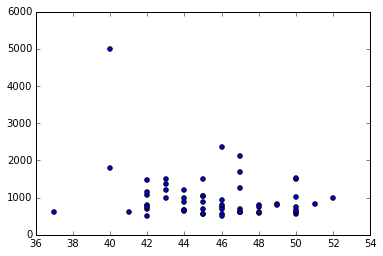

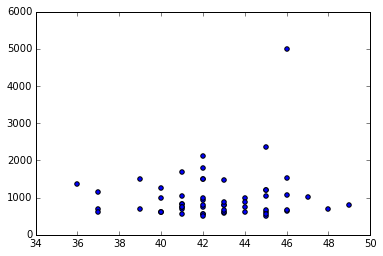

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,McConnell,Grimes,Undecided,Pollster URL,Source URL,Partisan,Affiliation
0,PPP (D),2014-10-30,2014-11-01,2014-11-02 01:44:58,1503,Likely Voters,IVR/Online,50,42,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.publicpolicypolling.com/pdf/2014/PP...,Pollster,Dem
1,NBC/Marist,2014-10-27,2014-10-30,2014-11-02 14:37:22,556,Likely Voters,Live Phone,50,41,3,http://elections.huffingtonpost.com/pollster/p...,http://newscms.nbcnews.com/sites/newscms/files...,Nonpartisan,None
2,SurveyUSA/Courier-Journal/Herald-Leader/WHAS/WKYT,2014-10-25,2014-10-29,2014-10-30 23:33:59,597,Likely Voters,IVR/Online,48,43,6,http://elections.huffingtonpost.com/pollster/p...,http://www.surveyusa.com/client/PollReport.asp...,Nonpartisan,None
3,POS (R-Crossroads GPS),2014-10-25,2014-10-27,2014-10-30 20:56:18,600,Likely Voters,Live Phone,50,43,NaN,http://elections.huffingtonpost.com/pollster/p...,https://www.crossroadsgps.org/wp-content/uploa...,Sponsor,Rep
4,CBS/NYT/YouGov,2014-10-16,2014-10-23,2014-10-26 15:00:07,1502,Likely Voters,Internet,45,39,14,http://elections.huffingtonpost.com/pollster/p...,https://today.yougov.com/news/2014/09/07/battl...,Nonpartisan,None


In [33]:
plt.scatter(df.McConnell, df['Number of Observations'])
plt.show()
plt.scatter(df.Grimes, df['Number of Observations'])
plt.show()
df.head()

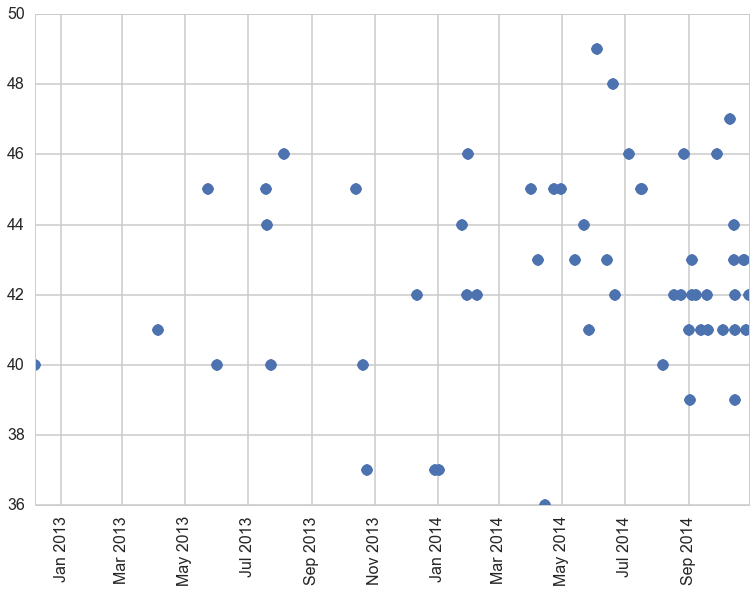

In [43]:
plt.plot_date(df['Start Date'], df.Grimes)
#plt.gca().invert_xaxis()
plt.xticks(rotation=90)
plt.show()

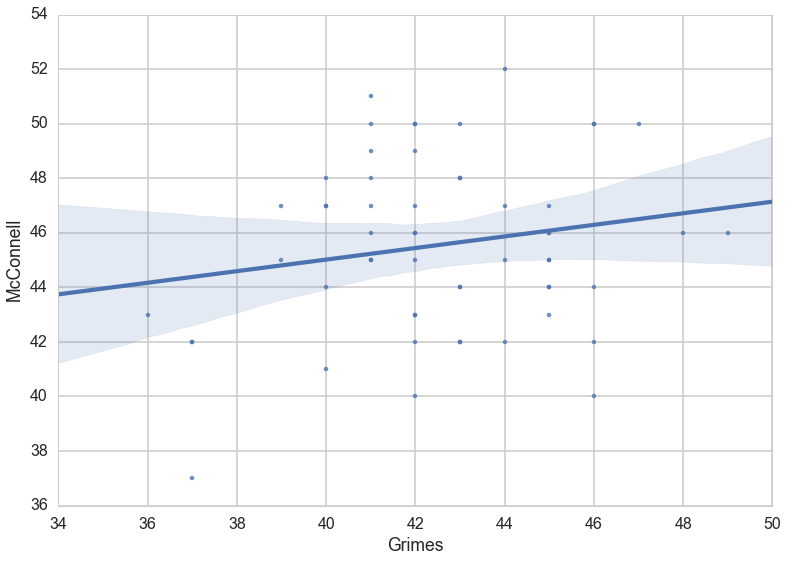

In [44]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

sns.regplot(y="McConnell", x="Grimes", data=df, fit_reg = True)

In [45]:
# Import regression modules
# ols - stands for Ordinary least squares, we'll use this
#    import statsmodels.api as sm
#    from statsmodels.formula.api import ols

In [ ]:
# statsmodels works nicely with pandas dataframes
# The thing inside the "quotes" is called a formula, a bit on that below
#    m = ols('PRICE ~ RM',bos).fit()
#    print m.summary()

In [80]:
candidateA = df.columns[7]
candidateB = df.columns[8]
meanA = round(df[candidateA].mean(),1)
meanB = round(df[candidateB].mean(),1)
stdA = round(df[candidateA].std(),1)
stdB = round(df[candidateB].std(),1)
print("Candidate A: " + candidateA + ", Mean=" + str(meanA) + ", SD=" + str(stdA))
print("Candidate B: " + candidateB + ", Mean=" + str(meanB) + ", SD=" + str(stdB))
winner = candidateA if meanA > meanB else candidateB
margin = meanA - meanB if meanA > meanB else meanB - meanA
print("Winner: " + winner) + ", by " + str(margin)

Candidate A: McConnell, Mean=45.6, SD=3.2
Candidate B: Grimes, Mean=42.6, SD=2.8
Winner: McConnell, by 3.0


In [105]:
for el, df in dfs.items():
    print(el)
    candidateA = df.columns[7]
    candidateB = df.columns[8]
    meanA = round(df[candidateA].mean(),1)
    meanB = round(df[candidateB].mean(),1)
    stdA = round(df[candidateA].std(),1)
    stdB = round(df[candidateB].std(),1)
#    print("Candidate A: " + candidateA + ", Mean=" + str(meanA) + ", SD=" + str(stdA))
#    print("Candidate B: " + candidateB + ", Mean=" + str(meanB) + ", SD=" + str(stdB))
    (winner, loser, margin, meanW, meanL, stdW, stdL) = \
        (candidateA, candidateB, meanA - meanB, meanA, meanB, stdA, stdB)\
        if meanA > meanB \
        else (candidateB, candidateA, meanB - meanA, meanB, meanA, stdB, stdA)
    print("Winner: " + winner + ", by " + str(margin) + " over " + loser)
    print(meanW, stdW, meanL, stdL)
    print

2014-kentucky-senate-mcconnell-vs-grimes
Winner: McConnell, by 3.0 over Grimes
(45.6, 3.2, 42.6, 2.8)

2014-montana-senate-daines-vs-curtis
Winner: Daines, by 17.2 over Curtis
(53.3, 3.0, 36.1, 3.4)

2014-north-carolina-senate-tillis-vs-hagan
Winner: Hagan, by 2.6 over Tillis
(44.3, 2.8, 41.7, 3.4)

2014-tennessee-senate-alexander-vs-ball
Winner: Alexander, by 19.0 over Ball
(50.2, 3.4, 31.2, 3.1)

2014-michigan-senate-land-vs-peters
Winner: Peters, by 5.7 over Land
(44.3, 5.2, 38.6, 3.3)

2014-wyoming-senate
Winner: Enzi, by 44.8 over Hardy
(67.8, 4.4, 23.0, 4.2)

2014-alaska-senate-sullivan-vs-begich
Winner: Begich, by 0.3 over Sullivan
(43.2, 2.7, 42.9, 4.4)

2014-oregon-senate-wehby-vs-merkley
Winner: Merkley, by 13.4 over Wehby
(49.1, 4.1, 35.7, 3.9)

2014-new-hampshire-senate-brown-vs-shaheen
Winner: Shaheen, by 5.4 over Brown
(48.0, 2.8, 42.6, 4.1)

2014-mississippi-senate-cochran-vs-childers
Winner: Cochran, by 15.5 over Childers
(46.6, 3.2, 31.1, 3.6)

2014-rhode-island-senate

In [ ]:
# target variable
# train-validate-test
# build prediction
# apply model to test data


# Submission Instructions

To submit your homework, create a folder named **lastname_firstinitial_hw#** and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code.  Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. *If we cannot access your work because these directions are not followed correctly, we will not grade your work.*
